In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('talk', font_scale=1.5)
sns.set(color_codes=True)

%matplotlib inline

In [2]:
import csv
import pandas as pd

def get_weeks():
    with open('rmnp_raw.csv', 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        current_frame = []
        for row in csvreader:
            if row == ['', '', '', '', '', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']:
                if current_frame:
                    yield current_frame
                current_frame = []
            else:
                current_frame += [row]
            

In [3]:
dfs = [pd.DataFrame(iframe[1:], columns=iframe[0]).iloc[:, 5:] for iframe in get_weeks()]

df_stacked = pd.concat(dfs, 1).T

df_stacked.index = df_stacked.index.to_datetime()

In [4]:
iframe = next(get_weeks())
site_details = pd.DataFrame(iframe[1:], columns=iframe[0]).iloc[:, :5]
site_details.columns = ['Code', 'Description', 'Distance', 'Elevation', 'SnowFreeDate']
#site_details['Code'] = site_details.Code.apply(lambda x: x[:3])
site_details.head()

,Code,Description,Distance,Elevation,SnowFreeDate
0,040,Andrews Creek (Waste Bag),3.6,10560,7/02
1,026,Arch Rock,1.6,8240,5/13
2,052IS,Aspen Knoll Llama,2.3,9400,5/26
3,005G,Aspen Meadow Group (WF),5.9,9520,5/31
4,043G,Battle Mountain Group,2.8,11000,6/18


In [5]:
def process_code(code):
    try:
        return '{:03d}'.format(int(code))
    except ValueError:
        return code

html_details = pd.read_html('https://www.nps.gov/romo/planyourvisit/site_details.htm', header=0)
site_details_html = pd.concat(html_details[4:], 0)
site_details_html['Site Name'] = site_details_html['Site Name'].str.strip('*')
site_details_html['Site Code'] = site_details_html['Site Code'].apply(process_code)
site_details_html.head()
site_details_html.columns = ['Code', 'Description', 'SnowFreeDate', 'NumSites',
                             'Distance', 'Elevation', 'ElevationGain', 'Privy']

def format_group_code(row):
    code = row.Code
    if 'Group' in row.Description:
        code += 'G'
    if ('Stock' in row.Description) | ('Stk' in row.Description):
        code += 'S'
    return code

site_details_html.head()

,Code,Description,SnowFreeDate,NumSites,Distance,Elevation,ElevationGain,Privy
0,NaN,Dunraven Trailhead,NaN,NaN,NaN,7960,NaN,NaN
1,001,Boundary Creek,6/2,2.0,4.6,9120,1160.0,Yes
2,002,Kettle Tarn,CLOSED,NaN,NaN,NaN,NaN,NaN
3,003,Silvanmere,6/4,2.0,5.6,9360,1400.0,No
4,004,Halfway,6/2,1.0,5.6,9340,1380.0,Yes


In [6]:
code_lookup = site_details_html.drop_duplicates(subset='Code')
code_lookup.set_index('Code', inplace=True)

def get_details(code):
    try:
        row = code_lookup.loc[code[:3]]
        
        return pd.Series(
            {'Code': code,
             'ElevationGain': row.ElevationGain,
             'Privy': row.Privy})

    except KeyError:
        return pd.Series({'Code' : code})
    
sites = site_details.merge(site_details.Code.apply(get_details), on='Code')
sites.head()

,Code,Description,Distance,Elevation,SnowFreeDate,ElevationGain,Privy
0,040,Andrews Creek (Waste Bag),3.6,10560,7/02,1320.0,RES2
1,026,Arch Rock,1.6,8240,5/13,90.0,No
2,052IS,Aspen Knoll Llama,2.3,9400,5/26,900.0,No
3,005G,Aspen Meadow Group (WF),5.9,9520,5/31,1560.0,Yes
4,043G,Battle Mountain Group,2.8,11000,6/18,1600.0,Yes


In [7]:
df_stacked.columns = sites.Code

availability = df_stacked\
    .applymap(lambda x: x if x != 'FULL' else 0)\
    .applymap(lambda x: x if x != 'NA' else pd.np.nan)\
    .dropna(1).astype(int)

# Here i'm assuming no site is completely booked
max_availability = availability.max(0)

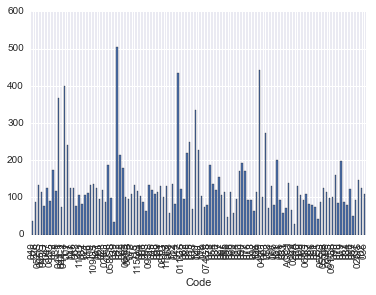

In [8]:
availability.sum(0).plot.bar()

In [14]:
sites = sites.set_index('Code')
sites['MaxNum'] = max_availability

In [17]:
sites.loc[availability.columns].to_csv('sites.csv')

In [18]:
availability.to_csv('availability.csv')